In [1]:
import numpy as np
def bandit(A,k=10):
    np.random.seed(42)
    means=np.random.normal(0,1,k)
    return np.random.normal(means[A],1)
def epsilon_greedy_bandit(k,epsilon,steps):
    Q=np.zeros(k)
    N=np.zeros(k)
    for _ in range(steps):
        if np.random.random>epsilon:
            Q_max=np.max(Q)
            max_actions=np.where(Q==Q_max)[0]
            A=np.random.choice(max_actions)
        else:
            A=np.random.randit(0,k)
        R=bandit(A,k)
        N[A] += 1
        Q[A] += (R - Q[A]) / N[A]
    return Q,N

page 97

In [4]:
class GridWorld:
    def __init__(self,rows=4,cols=4,gamma=0.9):
        self.rows=rows
        self.cols=cols
        self.gamma=gamma
        self.states=[(r,c) for r in range(rows) for c in range(cols)]
        self.transitions={}
        self.rewards={}
        self.actions=['up','down','left','right']
        self.terminal_states=[(0,0),(3,3)]
        self._initialize_environment()
    def _initialize_environment(self):
        for state in self.states:
            for action in self.actions:
                next_state=self._get_next_state(state,action)
                self.transitions[(state,action)]=[(next_state,1)]
                if state in self.terminal_states:
                    self.rewards[(state,action,next_state)]=0
                else:
                    self.rewards[(state,action,next_state)]=-1

    def _get_next_state(self, state, action):
        r, c = state
        if state in self.terminal_states:
            return state  # Stay in terminal state
        if action == 'up':
            return (max(r - 1, 0), c)
        elif action == 'down':
            return (min(r + 1, self.rows - 1), c)
        elif action == 'left':
            return (r, max(c - 1, 0))
        elif action == 'right':
            return (r, min(c + 1, self.cols - 1))
        return state
def iterative_policy_evaluation(gridworld,policy,theta=0.01):
    V={state:0.0 for state in gridworld.states}
    while True:
        delta=0.0
        for state in gridworld.states:
            if state in gridworld.terminal_states:
                continue
            v=V[state]
            new_value=0.0
            for action in gridworld.actions:
                pi_a_s=policy.get((state,action),0.0)
                for next_state,prob in gridworld.transitions[(state,action)]:
                    reward=gridworld.rewards.get((state,action,next_state),0.0)
                    new_value += pi_a_s * prob * (reward + gridworld.gamma * V[next_state])
            V[state] = new_value
            delta = max(delta, abs(v - V[state]))  # Update max change
        if delta < theta:
            break

    return V
if __name__ == "__main__":
    # Create environment
    gridworld = GridWorld(rows=4, cols=4, gamma=0.9)

    # Define a uniform policy: π(a|s) = 0.25 for each action
    policy = {}
    for state in gridworld.states:
        for action in gridworld.actions:
            policy[(state, action)] = 0.25  # Uniform probability

    # Run iterative policy evaluation
    V = iterative_policy_evaluation(gridworld, policy, theta=0.01)

    # Print the value function
    print("State-Value Function V(s):")
    for r in range(gridworld.rows):
        row = []
        for c in range(gridworld.cols):
            state = (r, c)
            row.append(f"{V[state]:.2f}")
        print(" ".join(row))
                
            
            

State-Value Function V(s):
0.00 -5.26 -7.10 -7.62
-5.26 -6.59 -7.16 -7.11
-7.10 -7.16 -6.59 -5.27
-7.62 -7.11 -5.27 0.00


In [4]:
import numpy as np
from collections import defaultdict

In [5]:
def policy_iterations(states,actions_per_state,transition_probs,gamma=0.9,theta=1e-4):
    V={s:0.0 for s in states}
    pi={s:np.random.choice(actions_per_state[s]) for s in states}

    while True:
        while True:
            delta=0
            for s in states:
                v=V[s]
                action=pi[s]
                expected_value=0.0
                for next_state,prob,reward in transition_probs.get((s,action),[]):
                    expected_value+=prob*(reward+gamma*V[next_state])
                V[s]=expected_value
                delta=max(delta,abs(v-V[s]))
                if delta>theta:
                    break
        policy_stable=True
        for s in states:
            old_action=pi[s]
            best_action=None
            # Find action that maximizes sum_{s',r} p(s',r|s,a) [r + gamma * V(s')]
            max_value=float('-inf')
            for action in actions_per_state[s]:
                expected_value=0
                for next_state,prob,reward in transition_probs.get((s,action),[]):
                    expected_value+=prob*(reward+gamma*V[next_state])
                if expected_value>max_value:
                    max_value=expected_value
                    best_action=action
            pi[s]=best_action
            if old_action != best_action:
                policy_stable=False
        if policy_stable:
            break
    return V,pi
def create_example_mdp():
    states = ['s0', 's1', 's2']
    # Define state-dependent actions A(s)
    actions_per_state = {
        's0': ['a0', 'a1'],
        's1': ['a0', 'a1'],
        's2': ['a0', 'a1']
    }
    
    # transition_probs[(s, a)] = [(next_state, prob, reward), ...]
    transition_probs = {
        ('s0', 'a0'): [('s1', 0.7, 1.0), ('s2', 0.3, 0.0)],
        ('s0', 'a1'): [('s2', 1.0, 2.0)],
        ('s1', 'a0'): [('s0', 0.5, 0.5), ('s1', 0.5, 1.0)],
        ('s1', 'a1'): [('s2', 1.0, 1.5)],
        ('s2', 'a0'): [('s0', 1.0, 0.0)],
        ('s2', 'a1'): [('s1', 1.0, 0.5)]
    }
    
    return states, actions_per_state, transition_probs
            
        

In [7]:
class MDP:
    def __init__(self):
        self.states=[]
        self.actions=[]
        self.transitions={}
        self.gamma=0.0
        self.theta=0.0
def value_iteration(mdp):
    V={s:0.0 for s in mdp.states}
    for s in mdp.states:
        if s=='terminal':
            V[s]=0.0
        
    while True:
        delta=0.0
        for s in mdp.states:
            if s=='terminal':
                continue
            old_v=V[s]
            new_v=float('-inf')
            for a in mdp.actions:
                expected_value=0
                for next_state,reward,prob in mdp.transtions[s][a]:
                    expected_value+=prob*(reward+gamma*V[new_state])
                new_v=max(new_v,expected_value)
            V[s]=new_v
            delta=max(delta,abs(old_v-[s]))
            if delta<mdp.theta:
                break
    policy = {}
    for s in mdp.states:
        if s == 'terminal':
            policy[s] = None
            continue
        best_action, best_value = None, float('-inf')
        for a in mdp.actions:
            expected_value = 0
            for next_state, reward, prob in mdp.transitions[s][a]:
                expected_value += prob * (reward + mdp.gamma * V[next_state])
            if expected_value > best_value:
                best_value = expected_value
                best_action = a
        policy[s] = best_action

    return V, policy

In [8]:
import numpy as np
from collections import defaultdict

In [9]:
def monte_carlo_policy_evaluation(policy,env,num_episodes=1000,gamma=1.0):
    V=defaultdict(float)
    Returns=defaultdict(float)
    for episode in range(num_episodes):
        episode_states=[]
        episode_actions=[]
        episode_rewards=[]
        state=env.reset()
        done=False
        while not done:
            action_probs=policy(state)
            action=np.random.choice(len(action_probs),p=action_probs)
            next_state,reward,done,_=env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state=next_state
        G = 0
        for t in range(len(episode_states) - 1, -1, -1):
            G = episode_rewards[t] + gamma * G
            state = episode_states[t]
            
            # First-visit MC: only update if state hasn't appeared earlier in episode
            if state not in episode_states[:t]:
                Returns[state].append(G)
                V[state] = np.mean(Returns[state])
    
    return V

In [10]:
def monte_carlo_es(env,num_episodes=1000,gamma=1.0):
    policy=defaultdict(lambda:0)
    Q=defaultdict(lambda:defaultdict(float))
    Returns=defaultdict(lambda:defaultdict(list))
    states=range(env.observation_space.n)
    actions=range(env.action_space.n)
    for episode in range(num_episodes):
        state=np.random.choice(states)
        action=np.random.choice(actions)
        env.reset()
        env.state=state
        episode_states=[state]
        episode_actions=[action]
        episode_rewards=[]

        next_step,reward,done,_=env.step(action)
        episode_rewards.append(reward)
        state=next_state
        while not done:
            action=policy[state]
            next_state,reward,done,_=env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state=next_state
        G=0
        for t in range(len(episode_states)-1,-1,-1):
            state,action=episode_states[t],episode_actions[t]
            G=episode_rewards[t]+gamma*G
            earlier_pairs=set(zip(episode_states[:t],episode_actions[:t]))
            if (state,action) not in earlier_pairs:
                Returns[state][action].append(G)
                Q[state][action]=np.mean(Returns[state][action])
                policy[state] = np.argmax([Q[state][a] for a in actions])
    
    return policy, Q

In [11]:
def monte_carlo_es_efficient(policy,num_episodes=10000,gamma=1.0):
    policy=defaultdict(lambda:0)
    Q=defaultdict(lambda:defaultdict(float))
    Count=defaultdict(lambda:defaultdict(int))
    states=range(env.observation_space.n)
    actions=range(env.action_space.n)
    for episode in range(num_episodes):
        state=np.random.choice(states)
        action=np.random.choice(actions)
        env.reset()
        env.state=state
        episode_states=[state]
        episode_actions=[action]
        episode_rewards=[]
        next_state,reward,done,_=env.step(action)
        episode_rewards.append(reward)
        state=next_state
        while not done:
            action=policy(state)
            next_state,reward,done,_=env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state=next_state
        G=0
        for t in range(len(episode_states)-1,-1,-1):
            state,action=episode_states[t],episode_actions[t]
            G=episode_rewards[t]+gamma*G
            earlier_pairs = set(zip(episode_states[:t], episode_actions[:t]))
            if (state, action) not in earlier_pairs:
                Count[state][action] += 1
                Q[state][action] += (1 / Count[state][action]) * (G - Q[state][action])
                
                # Policy improvement
                policy[state] = np.argmax([Q[state][a] for a in actions])
    
    return policy, Q

In [13]:
def epsilon_soft_monte_carlo(env,episodes=1000,epsilon=0.1,gamma=1.0):
    num_actions=env.action_space.n
    policy=defaultdict(lambda:np.ones(num_actions)/num_actions)
    Q=defaultdict(lambda:defaultdict(float))
    Returns=defaultdict(lambda:defaultdict(list))
    for episode in range(episodes):
        state=env.reset()
        episode_states=[]
        episode_actions=[]
        episode_rewards=[]
        done=False
        while not done:
            action_prob=policy[state]
            action=np.random.choice(num_actions,p=action_prob)
            next_state,reward,done,_=env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state=next_state
        G=0
        for t in range(len(episode_states)-1,-1,-1):
            state,action=episode_states[t],episode_actions[t]
            G=episode_rewards+gamma*G
            earlier_pairs=set(zip(episode_states[:t],episode_actions[:t]))
            if (state, action) not in earlier_pairs:
                Returns[state][action].append(G)
                Q[state][action] = np.mean(Returns[state][action])
                
                # Update epsilon-soft policy
                best_action = np.argmax([Q[state][a] for a in range(num_actions)])
                for a in range(num_actions):
                    if a == best_action:
                        policy[state][a] = 1 - epsilon + epsilon / num_actions
                    else:
                        policy[state][a] = epsilon / num_actions
    
    return policy, Q


In [15]:
def off_policy_monte_carlo(env,num_episodes=1000,epsilon=0.1,gamma=1.0):
    num_actions=env.action_space.n
    Q=defaultdict(lambda:defaultdict(float))
    C=defaultdict(lambda:defaultdict(float))
    pi=defaultdict(lambda:0)

    def behavior_policy(state):
        probs=np.ones(num_actions)*epsilon/num_actions
        best_actions=pi[state]
        probs[best_action]+=(1-epsilon)
        return probs
    for episode in range(num_episodes):
        state=env.reset()
        episode_states=[]
        episode_actions=[]
        episode_rewards=[]
        done=False

        while not done:
            action_probs=behavior_policy(state)
            action=np.random.choice(num_actions,p=action_probs)
            next_state,reward,done,_=env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state=next_state
        G=0
        W=1
        for t in range(len(episode_states)-1,-1,-1):
            state,action=episode_states[t],episode_actions[t]
            G=episode_rewards[t]+gamma*G
            if W==0:
                break
            C[state][action]+=W
            Q[state][action]+=(W/C[state][action])*(G-Q[state][action])
            pi[state]=np.argmax([Q[state][a] for a in range(num_actions)])
            pi_prob = 1.0 if action == pi[state] else 0.0  # Deterministic pi
            b_prob = behavior_policy(state)[action]
            W *= pi_prob / b_prob
            
    return pi, Q
        

In [16]:
def off_policy_monte_carlo_early_exit(env,num_episodes=1000,epsilon=0.1,gamma=1):
    num_actions=env.action_space.n
    Q=defaultdict(lambda:defaultdict(float))
    C=defaultdict(lambda:defaultdict(float))
    pi=defaultdict(lambda:0)
    def behavior_policy(state):
        probs=np.ones(num_actions)*epsilon/num_actions
        probs[pi[state]]+=(1-epsilon)
        return probs
    for episode in range(num_episodes):
        state=env.reset()
        episode_states=[]
        episode_actions=[]
        episode_rewards=[]
        done=False
        while not done:
            action_prob=behavior_policy(state)
            action=np.random.choice(num_actions,p=action_prob)
            next_state,reward,done,_=env.step(action)
            episode_states.append(state)
            episode_actions.append(action)
            episode_rewards.append(reward)
            state=next_state
        G=0
        W=1
        for t in range(len(episode_states)-1,-1,-1):
            state,action== episode_states[t], episode_actions[t]
            G = episode_rewards[t] + gamma * G
            
            # Update C and Q
            C[state][action] += W
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])
            
            # Update target policy (argmax with tie-breaking)
            q_values = [Q[state][a] for a in range(num_actions)]
            pi[state] = np.argmax(q_values)  # Lowest index breaks ties
            
            # Early exit if action doesn't match target policy
            if action != pi[state]:
                break
            
            # Update importance sampling weight
            b_prob = behavior_policy(state)[action]
            W *= 1 / b_prob
    
    return pi, Q

# Blackjack #

In [17]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm 
import altair as alt

In [19]:
def create_invert_map(lst):
    return {v:i for i,v in enumerate(lst)}

In [ ]:
class BlackJack:
 
    cards=['A',2,3,4,5,6,7,8,9,10,10,10,10]
    agent_sums=[12,13,14,15,16,17,18,19,20,21]
    dealers_cards=['A',2,3,4,5,6,7,8,9,10]
    ace_usability = [False, True]  # Referenced as 0, 1
    actions_possible = ["S", "H"]  # Referenced as 0, 

    agent_sums_map,dealers_cards_map,ace_usability_map,actions_possible_map,cards_map=map(
        create_invert_map,[agent_sums,dealers_cards,ace_usability,actions_possible,cards])
    def __init__(self,M,epsilon,alpha,seed=0):
        self.seed=seed
        self.epsilon=epsilon
        self.alpha=alpha
        self.Q_hist=None
        self.initialize()
    def initialize(self):
        self.Q=np.zeros((len(self.agent_sums),len(self.dealers_cards),len(self.ace_usability),len(self.action_possible)))
        self.C=np.zeros_like(self.Q,dtype=int)
        # Create the data directory if it doesn't already exist.
        if not os.path.exists('data'):
            os.mkdir('data')
    def sampled_cards(self,N):
        sampled_cards=np.random.choice(self.cards,size=N,replace=True)
        return [c if c=='A' else int(c) for c in sampled_cards]
    def map_to_indices(self,agent_sum,dealers_card,usable_ace):
        return (
            self.agent_sums_map[agent_sum],
            self.dealers_cards_map[dealer_card],
            self.ace_usability_map[usable_ace])
    def behavior_policy(self, agent_sum, dealers_card, useable_ace):
        """Returns H (Hit) or S (Stick) to determine the actions to take during the game."""
        agent_sum_idx, dealers_card_idx, useable_ace_idx = self.map_to_indices(
            agent_sum, dealers_card, useable_ace
        )
        greedy_action = self.Q[
            agent_sum_idx, dealers_card_idx, useable_ace_idx, :
        ].argmax()
        do_greedy = np.random.binomial(1, 1 - self.epsilon + (self.epsilon / 2))
        if do_greedy:
            return self.actions_possible[int(greedy_action)]
        else:
            return self.actions_possible[int(not greedy_action)]

    def target_policy(self, agent_sum, dealers_card, useable_ace):
        """
        The target policy is the same as the behavior policy in on-policy learning. Note: this method is never actually
        referenced.
        """
        return self.behavior_policy(
            agent_sum=agent_sum, dealers_card=dealers_card, useable_ace=useable_ace
        )

    def is_ratio(self, states_remaining, actions_remaining):
        """The Importance Sampling ratio that can be overwritten for off policy control."""
        return 1
    @staticmethod
    def calc_sum_useable_ace(cards):
        cards_sum=sum([c for c in cards if c!='A'])
        ace_count=sum([c for c in cards if c=='A'])

        if ace_count==0:
            return cards_sum,False
        else:
            cards_sum_0=cards_sum+ace_sum
            cards_sum_1=cards_sum+10+ace_sum
            if cards_sum_1>21:
                return cards_sum_0,False
            return cards_sum_1,True
    def play_game(self):
        """
        Returns:
            states: a list of states, one for each time state.
            actions: a list of agent actions, one for each time state.
            reward: final return of the game. Either -1, 0, 1
            how: string describing how the game ended.
        """

        agent_cards = self.sample_cards(2)  # Agent is delt 2 cards
        dealers_card = self.sample_cards(1)[0]  # Dealer is (effectively) delt 1 cards

        states = [[agent_cards, dealers_card]]
        actions = []
        # Hit until agent_sum >= 12
        while True:
            agent_cards,dealer_card=states[-1]
            agent_sum,_=self.calc_sum_useable_ace(agent_cards)
            if agent_sum<12:
                actions.append('H')
                agent_cards_next=agent_cards+self.sample_cards(1)
                states.append([agent_cards_next,dealer_card])
            else:
                break
         # Play game according to agents policy
        while True:
            agent_cards,dealers_card=states[-1]
            agent_sum,useable_ace=self.calc_sum_useable_ace(agent_cards)
            action=self.behavior_policy(agent_sum=agent_sum,useable_ace=useable_ace,dealers_card=dealers_card)
            actions.append(action)
            if action=='S':
                states.append([action_cards,dealers_card])
                break
            else:
                agent_cards_next=agent_card+self.sample_state(1)
                states.append([agent_cards_next,dealers_card])
                agent_sum_next,useable_ace=self.calc_sum_useable_ace(agent_cards_next)
                if agent_cards_next>21:
                    how='bust'
                    reward=-1
                    return states,actions,reward,how
        # Dealer plays
        dealers_cards = [states[-1][1]] + self.sample_cards(1)  # Turn over card
        while True:
            dealers_sum, _ = self.calc_sum_useable_ace(dealers_cards)
            if dealers_sum > 21:
                how = "dealer_bust:" + ",".join([str(c) for c in dealers_cards])
                reward = 1
                return states, actions, reward, how
            if dealers_sum > 16:
                break
            else:
                dealers_cards += self.sample_cards(1)

        agent_sum, useable_ace = self.calc_sum_useable_ace(states[-1][0])

        # If the game hasn't already ended, determine the winner.
        if agent_sum == dealers_sum:
            return states, actions, 0, f"{agent_sum} = {dealers_sum}"
        elif agent_sum > dealers_sum:
            return states, actions, 1, f"{agent_sum} > {dealers_sum}"
        else:
            return states, actions, -1, f"{agent_sum} < {dealers_sum}"


    def get_hyper_str(self):
        """Returns a string uniquely identifying the class arguments."""
        return f"M{self.M}__epsilon{str(self.epsilon).replace('.', '_')}__alpha{str(self.alpha).replace('.', '_')}__seed{str(self.seed)}"
    def get_file_names(self):
        hyper_str = self.get_hyper_str()
        Q_name = "data\\Q_" + hyper_str
        C_name = "data\\C_" + hyper_str
        Q_hist_name = "data\\Q_hist_" + hyper_str
        return Q_name, C_name, Q_hist_name
    def save(self):
        Q_name, C_name, Q_hist_name = self.get_file_names()
        print(f"Saving {Q_name}")
        np.save(Q_name, self.Q)
        print(f"Saving {C_name}")
        np.save(C_name, self.C)
        if self.Q_hist is not None:
            print(f"Saving {Q_hist_name}")
            self.Q_hist.to_pickle(Q_hist_name + ".pkl")

    def load(self):
        Q_name, C_name, Q_hist_name = self.get_file_names()
        print(f"Loading...")
        self.Q = np.load(Q_name + ".npy")
        self.C = np.load(C_name + ".npy")
        try:
            self.Q_hist = pd.read_pickle(Q_hist_name + ".pkl")
        except:
            print("No Q hist to load")
    def _get_ms(self):
        """Returns a list of episodes index's (sometimes called 'm's) for which we record action-value pairs."""
        return list(range(0, self.M + 1, 1000))
    def mc_control(self, track_history=True):

        """Return the algorithm to learn the Q-table."""

        self.initialize()
        np.random.seed(self.seed)

        Q_hist = []
        ms = self._get_ms()

        for m in tqdm(range(self.M + 1)):
            states, actions, reward, how = self.play_game()

            if track_history:
                if m in ms:
                    Q_hist.append(self.get_df("Q").assign(m=m))

            for i, (state, action) in enumerate(zip(states[:-1], actions)):

                agent_cards, dealers_card = state
                agent_sum, useable_ace = self.calc_sum_useable_ace(agent_cards)

                if agent_sum < 12:
                    continue

                agent_sum_idx, dealers_card_idx, useable_ace_idx = self.map_to_indices(
                    agent_sum, dealers_card, useable_ace
                )
                actions_idx = self.actions_map[action]

                q_val = self.Q[
                    agent_sum_idx, dealers_card_idx, useable_ace_idx, actions_idx
                ]

                rho = self.is_ratio(states[i + 1 :], actions[i + 1 :])

                self.Q[
                    agent_sum_idx, dealers_card_idx, useable_ace_idx, actions_idx
                ] = q_val + self.alpha * (rho * reward - q_val)

                self.C[
                    agent_sum_idx, dealers_card_idx, useable_ace_idx, actions_idx
                ] += 1

        if track_history:
            self.Q_hist = pd.concat(Q_hist, axis=0)

        self.save()
    def plot_over_m(
        self, agent_sum, dealers_card, useable_ace, width=400, height=200, **kwargs
    ):
        """Creates a line plot of the action-value of hit and stick as episodes are processed. Note: we don't record
        action-value after every episodes, so not all action-values are shown."""

        if dealers_card == "A":
            dealers_card = f"'{dealers_card}'"

        df = self.Q_hist.query(
            f"(agent_sum == {agent_sum}) & (dealers_card == {dealers_card}) & (useable_ace == {useable_ace})"
        )[["Q", "action", "m"]]

        return (
            alt.Chart(df)
            .mark_line(**kwargs)
            .encode(x="m", y="Q", color="action")
            .properties(height=height, width=width)
        )

    def make_slice_df(self, Q_or_C_slice, name):
        df = pd.DataFrame(
            Q_or_C_slice, index=self.agent_sums, columns=self.dealers_cards
        )
        df.index.name = "agent_sum"
        df.columns.name = "dealers_card"
        return df.stack().to_frame(name)
    def get_df(self, which="Q"):

        assert which in ["Q", "C"]

        array = getattr(self, which)

        df = []
        for idx1 in [0, 1]:
            for idx2 in [0, 1]:

                slc = array[:, :, idx1, idx2]
                slc_df = self.make_slice_df(slc, which)

                if which == "Q":
                    opt = array.argmax(-1)[:, :, idx1]
                    is_opt = opt == idx2

                    slc_df = pd.concat(
                        [slc_df, self.make_slice_df(is_opt.astype(int), "opt")], axis=1
                    )

                slc_df = slc_df.reset_index().assign(
                    useable_ace=self.ace_usability[idx1],
                    action=self.actions_possible[idx2],
                )
                df.append(slc_df)

        return pd.concat(df, axis=0)
    def plot(self, which="Q", height=200, width=350):
        """Returns 2-by-2 grid of heatmaps giving either the action values or the counts each state-action pair was visited."""

        assert which in ["Q", "C"]

        df = self.get_df(which)

        if "Q" in df.columns:
            col = "Q"
            color = alt.Color(col, scale=alt.Scale(domain=[-1, 1]))
        else:
            col = "C"
            color = alt.Color(col)

        heatmap = (
            alt.Chart(df)
            .mark_rect()
            .encode(x="agent_sum:O", y="dealers_card:O", color=color,)
        )
        df["rounded"] = df[col].round(2)

        args = dict(x="agent_sum:O", y="dealers_card:O", text="rounded")
        txt = alt.Chart(df).mark_text().encode(**args)

        if which == "Q":
            opt = (
                alt.Chart(df)
                .mark_rect(fill=None, strokeWidth=2, stroke="green")
                .encode(x="agent_sum:O", y="dealers_card:O")
                .transform_filter(alt.datum.opt == 1)
            )
            chart = heatmap + opt + txt
        else:
            chart = heatmap + txt

        return chart.properties(height=height, width=width).facet(
            row="action", column="useable_ace"
        )
        
    
    
    
                       
            
                
                    


   
   

In [ ]:
class BlackJackOffPolicy(BlackJack):
    def __init__(self,M,alpha,seed=0):
        self.M=M
        self.alpha=alpha
        self.Q_hist=None
        self.seed=seed
        self.initialize()
    def behavior_policy(self, agent_sum, dealers_card, useable_ace):
        """Behavior policy is to select hit or stick with a 50/50 probability."""
        return np.random.choice(self.actions_possible)

    def target_policy(self, agent_sum, dealers_card, useable_ace):
        agent_sum_idx, dealers_card_idx, useable_ace_idx = self.map_to_indices(
            agent_sum, dealers_card, useable_ace
        )
        greedy_action = self.Q[
            agent_sum_idx, dealers_card_idx, useable_ace_idx, :
        ].argmax()
        return self.actions_possible[greedy_action]

    def get_hyper_str(self):
        return f"M{self.M}__OP__alpha{str(self.alpha).replace('.', '_')}__seed{str(self.seed)}"

    def is_ratio(self, states_remaining, actions_remaining):
        """
        In this case, the target policy is deterministic, so the importance sampling ratio will only be nonzero when the
        deterministic policy would have target that action.

        """
        for state, action in zip(states_remaining, actions_remaining):
            agent_cards, dealers_card = state
            agent_sum, useable_ace = self.calc_sum_useable_ace(agent_cards)
            target_action = self.target_policy(agent_sum, dealers_card, useable_ace)
            if target_action != action:
                return 0.0

        return 1.0 / (0.5 ** len(actions_remaining))
    

In [ ]:
import numpy as np

class GridWorld:
    def __init__(self):
        self.state_space = list(range(4))  # States: 0, 1, 2, 3
        self.action_space = list(range(4))  # Actions: 0=left, 1=right, 2=up, 3=down
        self.goal = 3  # Goal at bottom-right
        self.trap = 1  # Trap at top-right
        self.reset()
    
    def reset(self):
        """Initialize to starting state (top-left)."""
        self.state = 0
        return self.state
    
    def step(self, action):
        """Take action, return (next_state, reward, done, info)."""
        # Current position (row, col) from state (0 to 3)
        row, col = divmod(self.state, 2)  # 2x2 grid
        
        # Compute next position based on action
        if action == 0:  # Left
            col = max(col - 1, 0)
        elif action == 1:  # Right
            col = min(col + 1, 1)
        elif action == 2:  # Up
            row = max(row - 1, 0)
        elif action == 3:  # Down
            row = min(row + 1, 1)
        
        # New state
        next_state = row * 2 + col
        
        # Reward and done
        reward = -0.1  # Step penalty
        done = False
        if next_state == self.goal:
            reward = 1.0
            done = True
        elif next_state == self.trap:
            reward = -1.0
            done = True
        
        self.state = next_state
        return next_state, reward, done, {}
    
    def render(self):  # Optional: Visualize state
        grid = [['.' for _ in range(2)] for _ in range(2)]
        row, col = divmod(self.state, 2)
        grid[row][col] = 'A'  # Agent
        grid[0][1] = 'T'  # Trap
        grid[1][1] = 'G'  # Goal
        print("\n".join(" ".join(row) for row in grid))

# Test with Q-learning
def q_learning(env, num_episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    from collections import defaultdict
    Q = defaultdict(lambda: defaultdict(float))
    num_actions = len(env.action_space)
    
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax([Q[state][a] for a in range(num_actions)])
            
            next_state, reward, done, _ = env.step(action)
            next_q = max([Q[next_state][a] for a in range(num_actions)] if not done else [0])
            Q[state][action] += alpha * (reward + gamma * next_q - Q[state][action])
            state = next_state
    
    pi = defaultdict(lambda: 0)
    for state in Q:
        pi[state] = np.argmax([Q[state][a] for a in range(num_actions)])
    return pi, Q

if __name__ == "__main__":
    env = GridWorld()
    pi, Q = q_learning(env)
    print("Learned Policy:", {s: pi[s] for s in sorted(pi.keys())})
    # Example episode
    state = env.reset()
    env.render()
    done = False
    while not done:
        action = pi[state]
        state, reward, done, _ = env.step(action)
        print(f"Action: {action}, Reward: {reward}")
        env.render()

# chapter 6

In [24]:
def policy_evaluation(policy,env,alpha=0.1,gamma=0.9,num_episodes=1000):
    V=np.zeros(env.observation_space.n)
    for episode in range(num_episodes):
        state=env.reset()
        done =False
        while not done:
            action=policy[state]
            next_state,reward,done,_=env.step(action)
            V[state]+= alpha*(reward+gamma*V[next_state]-V[state])
            state=next_state
    return V

In [26]:
episodes = [
    [('A', 0), ('B', 0)],
    [('B', 1)],
    [('B', 1)],
    [('B', 1)],
    [('B', 1)],
    [('B', 1)],
    [('B', 1)],
    [('B', 0)],
]

states = ['A', 'B']

def monte_carlo_value_estimates(episodes):
    returns = defaultdict(list)

    for episode in episodes:
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, reward = episode[t]
            G = reward + G
            if state not in visited:
                returns[state].append(G)
                visited.add(state)

    V = {s: sum(returns[s]) / len(returns[s]) if returns[s] else 0 for s in states}
    return V

def td0_batch_update(episodes,max_iterations=1000,theta=1e-4):
    V={s:0 for s in states}
    for iteration in range(max_iterations):
        total_change=0
        updates=defaultdict(float)
        counts=defaultdict(int)

        for episode in episodes:
            for t in range(len(episodes)-1):
                s,r=episode[t]
                s_next,_=episode[t+1]
                td_target=r+V[s_next]
                td_error=td_target-V[s]
                updates[s]+=td_error
                counts[s]+=1
            for s in updates:
                 mean_update = updates[s] / counts[s]
                 V[s] += mean_update
                 total_change = max(total_change, abs(mean_update))
           

        if total_change < theta:
            break

    return V


In [28]:
def epsilon_greedy_policy(Q,state,env,epsilon):
    if np.random.rand()<epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])
def sarse(env,alpha=0.1,gamma=0.9,epsilon=0.1,num_episodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    for episode in range(num_episdoes):
        state=env.reset()
        action=epsilon_greedy_policy(Q,state,env,epsilon)
        done=False
        while not done:
            next_state,reward,done,_=env.step(action)
            next_action=epsilon_greedy_policy(Q,next_state,env,epsilon)
            Q[state,action]+=aplha*(reward+gamma*Q[next_state,next_action]-Q[state,action])
            state = next_state
            action = next_action
    
    # Derive greedy policy from Q
    policy = np.argmax(Q, axis=1)
    
    return Q, policy
        

In [29]:
def q_learning(env,alpha=0.1,epsilon=0.1,gamma=0.9,num_episodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    for episode in range(num_episodes):
        state=env.reset
        
        done=False
        while not done:
            action=epsilon_greedy_policy(Q<state,env,epsilon)
            next_state,reward,done,_=env.step(action)
            Q[state,action]+=alpha*(reward+gamma*np.max(Q[next_state])-Q[state,action])
            state=next_state

    policy=np.argmax(Q,axis=1)
    return Q,policy

# expected sarsa

In [30]:
def get_action_prob(Q,state,env,epsilon):
    num_actions=env.action_space.n
    probs=np.ones(num_actions)*epsilon/num_actions
    best_action=np.argmax(Q[state])
    probs[best_action]+=(1-epsilon)
    return probs

def expected_sarsa(env,alpha=0.1,gamma=0.9,epsilon=0.1,num_episodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    for episode in range(num_episodes):
        state=env.reset()
       
        done=False
        while not done:
            action=epsilon_greedy_policy(Q,state,env,epsilon)
            next_state,reward,done,_=env.step(action)
            next_action=epsilon_greedy_policy(Q,next_state,env,epsilon)
            action_prob=get_action_prob(Q,next_state,env,epsilon)
            action_sum=np.sum(action_prob*Q[next_state])
            Q[state,action]+=alpha*(reward+action_sum - Q[state,action])
            state = next_state
    
    # Derive greedy policy from Q
    policy = np.argmax(Q, axis=1)
    
    return Q, policy
            

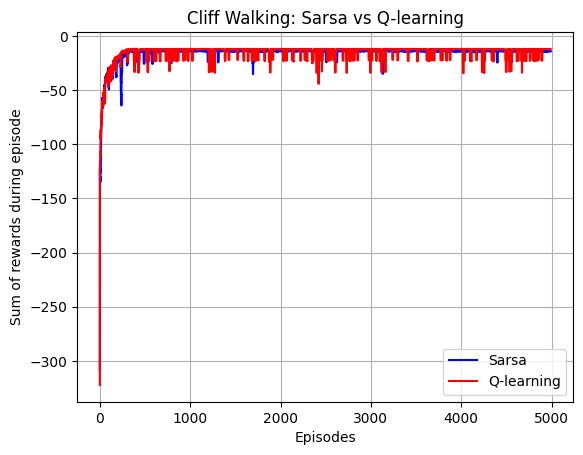

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Environment settings
HEIGHT = 4
WIDTH = 12
START = (3, 0)
GOAL = (3, 11)
CLIFF = [(3, i) for i in range(1, 11)]
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_MAP = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}

# Parameters
EPISODES = 5000
EPSILON = 0.01
ALPHA = 0.1
GAMMA = 1.0

def step(state, action):
    """Take an action in the environment and return new state, reward, and terminal status."""
    i, j = state
    di, dj = ACTION_MAP[action]
    ni, nj = max(0, min(HEIGHT - 1, i + di)), max(0, min(WIDTH - 1, j + dj))
    next_state = (ni, nj)
    reward = -1
    done = False
    if state == GOAL:
        return state, 0, True
    if next_state in CLIFF:
        return START, -100, False
    if next_state == GOAL:
        return next_state, 0, True
    return next_state, reward, False

def choose_action(state, Q, epsilon):
    """ε-greedy action selection."""
    if np.random.rand() < epsilon:
        return np.random.choice(ACTIONS)
    q_vals = np.array([Q[state][a] for a in ACTIONS])
    return ACTIONS[np.argmax(q_vals)]

def sarsa():
    """SARSA agent."""
    Q = defaultdict(lambda: {a: 0.0 for a in ACTIONS})
    rewards = []
    for ep in range(EPISODES):
        state = START
        action = choose_action(state, Q, EPSILON)
        total_reward = 0
        while state != GOAL:
            next_state, reward, done = step(state, action)
            next_action = choose_action(next_state, Q, EPSILON)
            Q[state][action] += ALPHA * (reward + GAMMA * Q[next_state][next_action] - Q[state][action])
            state = next_state
            action = next_action
            total_reward += reward
        rewards.append(total_reward)
    return rewards

def q_learning():
    """Q-learning agent."""
    Q = defaultdict(lambda: {a: 0.0 for a in ACTIONS})
    rewards = []
    for ep in range(EPISODES):
        state = START
        total_reward = 0
        while state != GOAL:
            action = choose_action(state, Q, EPSILON)
            next_state, reward, done = step(state, action)
            best_next = max(Q[next_state].values())
            Q[state][action] += ALPHA * (reward + GAMMA * best_next - Q[state][action])
            state = next_state
            total_reward += reward
        rewards.append(total_reward)
    return rewards

# Run both agents
sarsa_rewards = sarsa()
q_learning_rewards = q_learning()

# Smooth rewards
def moving_average(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Plot results
plt.plot(moving_average(sarsa_rewards), label="Sarsa", color='blue')
plt.plot(moving_average(q_learning_rewards), label="Q-learning", color='red')
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.title("Cliff Walking: Sarsa vs Q-learning")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
def epsilon_greedy_policy(Q1,Q2,state,env,epsilon):
    if np.random.rand()<epsilon:
        return env.action_space.sample()
    else:
        Q_combined=Q1[state]+Q2[state]
        return np.argmax(Q_combined)

def double_q_learning(env,alpha=0.1,gamma=0.9,epsilon=0.1,num_episodes=1000):
    Q1 = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in range(num_episodes):
        # Initialize state
        state = env.reset()
        
        # Loop until episode terminates
        done = False
        while not done:
            # Choose action using epsilon-greedy policy based on Q1 + Q2
            action = epsilon_greedy_policy(Q1, Q2, state, env, epsilon)
            
            # Take action, observe reward and next state
            next_state, reward, done, _ = env.step(action)
            
            # Update Q1 or Q2 with 0.5 probability
            if np.random.rand() < 0.5:
                # Update Q1: Q1(S, A) ← Q1(S, A) + α[R + γ Q2(S', argmax_a Q1(S', a)) - Q1(S, A)]
                best_next_action = np.argmax(Q1[next_state])
                Q1[state, action] += alpha * (reward + gamma * Q2[next_state, best_next_action] - Q1[state, action])
            else:
                # Update Q2: Q2(S, A) ← Q2(S, A) + α[R + γ Q1(S', argmax_a Q2(S', a)) - Q2(S, A)]
                best_next_action = np.argmax(Q2[next_state])
                Q2[state, action] += alpha * (reward + gamma * Q1[next_state, best_next_action] - Q2[state, action])
            
            # Update state
            state = next_state
    
    # Derive greedy policy from Q1 + Q2
    Q_combined = Q1 + Q2
    policy = np.argmax(Q_combined, axis=1)
    
    return Q1, Q2, policy

# Chapter 7

In [35]:
def n_step_td(env,policy,alpha=0.1,gamma=0.9,n=5,num_episodes=10000):
    V=np.zeros(env.observation_space.n)
    for episode in range(num_episodes):
        state=env.reset()
        states=[state]
        rewards=[0]
        T=float('inf')
        t=0
        while True:
            if t<T:
                action=policy[state]
                next_state,reward,done,_=env.step(action)
                states.append(next_state)
                rewards.append(reward)
                if done:
                    T=t+1
            tau=t-n-1
            if tau>=0:
                G=0
                for i in range(tau + 1, min(tau + n, T) + 1):
                     G += (gamma ** (i - tau - 1)) * rewards[i]
                if tau+n<T:
                    G += (gamma ** n) * V[states[tau + n]]
                V[states[tau]]+=alpha*(G-V[states[tau]])
            t += 1
            state = next_state
            
            # Break when tau reaches T-1
            if tau == T - 1:
                break
    
    return V

In [39]:
def epsilon_greedy_policy(Q,state,env,epsilon):
    if np.random.rand()<epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])


def n_step_sarsa(env,alpha=0.1,gamma=0.9,epsilon=0.1,n=5,num_episodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    for episode in range(num_episodes):
        state=env.reset()
        action=epsilon_greedy_policy(Q,state,env,epsilon)
        states=[state]
        actions=[action]
        rewards=[0]
        T=float('inf')
        t=0
        while True:
            if t<T:
                next_state,reward,done,_=env.step(action)
                states.append(next_state)
                rewards.append(reward)
                if done:
                    T=t+1
                else:
                    next_action=epsilon_greedy_policy(Q,next_state,env,epsilon)
                    actions.append(next_action)
            tau=t-n+1
            if tau>=0:
                G=0
                for i in range(tau+1,min(tau+n,T)+1):
                    G+=(gamma**(i-tau-1))*rewards[i]
                if tau+n<T:
                    G+=(gamma**n)*Q[states[tau+n],actions[tau+n]]
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
                
                # Ensure π(·|S_tau) is epsilon-greedy wrt Q (implicitly handled by policy function)
            
            # Move to next time step
            t += 1
            
            # Break when tau reaches T-1
            if tau == T - 1:
                break
    
    # Derive final epsilon-greedy policy
    policy = np.argmax(Q, axis=1)  # Greedy policy for evaluation
    
    return Q, policy

In [40]:

def epsilon_greedy_policy(Q, state, env, epsilon):
    """
    Returns an action using epsilon-greedy policy based on Q-values.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability (0 <= epsilon <= 1)
    
    Returns:
        action: Selected action
    """
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Random action
    else:
        return np.argmax(Q[state])  # Greedy action

def get_action_probabilities(Q, state, env, epsilon):
    """
    Returns action probabilities under epsilon-greedy policy.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability (0 <= epsilon <= 1)
    
    Returns:
        probs: Array of shape [n_actions] with action probabilities
    """
    n_actions = env.action_space.n
    probs = np.ones(n_actions) * epsilon / n_actions  # Uniform probability for exploration
    best_action = np.argmax(Q[state])
    probs[best_action] += (1.0 - epsilon)  # Add (1-ε) probability for greedy action
    return probs

def n_step_expected_sarsa(env, alpha=0.1, gamma=0.9, epsilon=0.1, n=3, num_episodes=1000):
    """
    N-step Expected SARSA algorithm for estimating Q-function.
    
    Args:
        env: Gym environment (Frozen Lake)
        alpha: Step size (0 < alpha <= 1)
        gamma: Discount factor (0 <= gamma <= 1)
        epsilon: Exploration probability for epsilon-greedy policy
        n: Number of steps for n-step Expected SARSA
        num_episodes: Number of episodes to run
    
    Returns:
        Q: Q-table of shape [n_states, n_actions]
        policy: Greedy policy derived from Q
    """
    # Initialize Q arbitrarily (except Q(terminal, ·) = 0)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in range(num_episodes):
        # Initialize and store S0 (non-terminal)
        state = env.reset()
        
        # Select and store A0 ~ π(·|S0)
        action = epsilon_greedy_policy(Q, state, env, epsilon)
        
        # Storage for states, actions, and rewards
        states = [state]  # S_0, S_1, ..., S_t
        actions = [action]  # A_0, A_1, ..., A_t
        rewards = [0]  # R_1, R_2, ..., R_t+1 (R_0 is dummy)
        
        T = float('inf')  # Time at which episode terminates
        t = 0  # Current time step
        
        while True:
            # If t < T, take action and observe
            if t < T:
                # Take action A_t
                next_state, reward, done, _ = env.step(actions[t])
                
                # Store next reward and state
                rewards.append(reward)
                states.append(next_state)
                
                if done:
                    # If S_{t+1} is terminal, set T
                    T = t + 1
                else:
                    # Select and store A_{t+1} ~ π(·|S_{t+1})
                    next_action = epsilon_greedy_policy(Q, next_state, env, epsilon)
                    actions.append(next_action)
            
            # Time whose estimate is being updated
            tau = t - n + 1
            
            # If tau >= 0, update Q(S_tau, A_tau)
            if tau >= 0:
                # Compute n-step return G
                G = 0
                # Sum rewards from tau+1 to min(tau+n, T)
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If tau + n < T, add expected value: γ^n * Σ_a π(a|S_{tau+n}) Q(S_{tau+n}, a)
                if tau + n < T:
                    action_probs = get_action_probabilities(Q, states[tau + n], env, epsilon)
                    expected_value = np.sum(action_probs * Q[states[tau + n]])
                    G += (gamma ** n) * expected_value
                
                # Update Q(S_tau, A_tau)
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
                
                # Ensure π(·|S_tau) is epsilon-greedy wrt Q (implicitly handled by policy function)
            
            # Move to next time step
            t += 1
            
            # Break when tau reaches T-1
            if tau == T - 1:
                break
    
    # Derive final greedy policy for evaluation
    policy = np.argmax(Q, axis=1)
    
    return Q, policy

In [45]:
def behavior_policy(env):
    return env.action_space.sample()
def get_behavior_policy_prob(env):
    return 1/env.action_space.n
def target_policy(Q,state):
    return np.argmax(Q[state])
def get_target_policy_prob(Q,state,action):
    greedy_action=np.argmax(Q[state])
    return 1.0 if action==greedy_action else 0.0
def off_policy_n_step_sarsa(env,alpha=0.1,gamma=0.9,n=5,num_episodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    for episode in range(num_episodes):
        states=env.reset()
        action=behavior_policy(env)
        states=[state]
        actions=[action]
        rewards=[0]
        T=float('inf')
        t=0
        while True:
           if t<T:
                next_state,reward,done,_=env.step(action)
                states.append(next_state)
                rewards.append(reward)
                if done:
                    T=t+1
                else:
                    next_action=behavior_policy(env)
                    actions.append(next_action)
        tau=t-n+1
        if tau >= 0:
                # Compute importance sampling ratio ρ
                rho = 1.0
                # Product from i = tau+1 to min(tau+n-1, T-1)
                for i in range(tau + 1, min(tau + n - 1, T - 1) + 1):
                    pi_prob = get_target_policy_prob(Q, states[i], actions[i])
                    b_prob = get_behavior_policy_prob(env)
                    rho *= pi_prob / b_prob
                
                # Compute n-step return G
                G = 0
                # Sum rewards from tau+1 to min(tau+n, T)
                for i in range(tau + 1, min(tau + n, T) + 1):
                    G += (gamma ** (i - tau - 1)) * rewards[i]
                
                # If tau + n < T, add discounted Q(S_{tau+n}, A_{tau+n})
                if tau + n < T:
                    G += (gamma ** n) * Q[states[tau + n], actions[tau + n]]
                
                # Update Q(S_tau, A_tau) with importance sampling
                Q[states[tau], actions[tau]] += alpha * rho * (G - Q[states[tau], actions[tau]])
                
                # Ensure π(·|S_tau) is greedy wrt Q (handled by target_policy)
            
            # Move to next time step
        t += 1
            
            # Break when tau reaches T-1
        if tau == T - 1:
                break
    
    # Derive final greedy policy
    policy = np.argmax(Q, axis=1)
    
    return Q, policy
            
            
    

In [46]:


def behavior_policy(env):
    """
    Returns an action using a uniform random policy (behavior policy b).
    
    Args:
        env: Gym environment
    
    Returns:
        action: Random action
    """
    return env.action_space.sample()

def get_behavior_policy_prob(env):
    """
    Returns the probability of an action under the uniform random behavior policy.
    
    Args:
        env: Gym environment
    
    Returns:
        prob: Probability of selecting any action
    """
    return 1.0 / env.action_space.n  # Uniform over all actions

def target_policy(Q, state, env, epsilon):
    """
    Returns an action using an epsilon-greedy policy (target policy π) based on Q-values.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability (0 <= epsilon <= 1)
    
    Returns:
        action: Selected action
    """
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

def get_target_policy_probs(Q, state, env, epsilon):
    """
    Returns action probabilities under the epsilon-greedy target policy π.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability (0 <= epsilon <= 1)
    
    Returns:
        probs: Array of shape [n_actions] with action probabilities
    """
    n_actions = env.action_space.n
    probs = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q[state])
    probs[best_action] += (1.0 - epsilon)
    return probs

def compute_v_bar(Q, state, env, epsilon):
    """
    Computes V_bar(s) = Σ_a π(a|s) Q(s, a) under the target policy π.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability for target policy
    
    Returns:
        v_bar: Expected Q-value under π
    """
    action_probs = get_target_policy_probs(Q, state, env, epsilon)
    return np.sum(action_probs * Q[state])

def compute_per_decision_return(t, h, T, states, actions, rewards, Q, gamma, env, epsilon):
    """
    Recursively computes the per-decision n-step return G_{t:h} with control variates.
    
    Args:
        t: Start time of the return
        h: Horizon time (t < h <= T)
        T: Terminal time
        states: List of states S_0, S_1, ...
        actions: List of actions A_0, A_1, ...
        rewards: List of rewards R_1, R_2, ...
        Q: Q-table of shape [n_states, n_actions]
        gamma: Discount factor
        env: Gym environment
        epsilon: Exploration probability for target policy
    
    Returns:
        G: N-step return G_{t:h}
    """
    # Base cases
    if t == h:
        return Q[states[h], actions[h]]  # G_{h:h} = Q_{h-1}(S_h, A_h)
    if t == T - 1 and h >= T:
        return rewards[T]  # G_{T-1:h} = R_T
    
    # Compute importance sampling ratio ρ_{t+1}
    pi_prob = get_target_policy_probs(Q, states[t + 1], env, epsilon)[actions[t + 1]]
    b_prob = get_behavior_policy_prob(env)
    rho = pi_prob / b_prob if b_prob > 0 else 0.0
    
    # Compute V_bar(S_{t+1})
    v_bar = compute_v_bar(Q, states[t + 1], env, epsilon)
    
    # Recursively compute G_{t+1:h}
    G_next = compute_per_decision_return(t + 1, h, T, states, actions, rewards, Q, gamma, env, epsilon)
    
    # G_{t:h} = R_{t+1} + γ ρ_{t+1} (G_{t+1:h} - Q(S_{t+1}, A_{t+1})) + γ V_bar(S_{t+1})
    G = rewards[t + 1] + gamma * rho * (G_next - Q[states[t + 1], actions[t + 1]]) + gamma * v_bar
    return G

def per_decision_n_step_sarsa(env, alpha=0.1, gamma=0.9, epsilon=0.1, n=3, num_episodes=1000):
    """
    Off-policy n-step SARSA with per-decision importance sampling and control variates.
    
    Args:
        env: Gym environment (Frozen Lake)
        alpha: Step size (0 < alpha <= 1)
        gamma: Discount factor (0 <= gamma <= 1)
        epsilon: Exploration probability for target policy
        n: Number of steps
        num_episodes: Number of episodes to run
    
    Returns:
        Q: Q-table of shape [n_states, n_actions]
        policy: Greedy policy derived from Q
    """
    # Initialize Q arbitrarily (except Q(terminal, ·) = 0)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in range(num_episodes):
        # Initialize and store S0 (non-terminal)
        state = env.reset()
        
        # Select and store A0 ~ b(·|S0)
        action = behavior_policy(env)
        
        # Storage for states, actions, and rewards
        states = [state]  # S_0, S_1, ..., S_t
        actions = [action]  # A_0, A_1, ..., A_t
        rewards = [0]  # R_1, R_2, ..., R_t+1 (R_0 is dummy)
        
        T = float('inf')  # Time at which episode terminates
        t = 0  # Current time step
        
        while True:
            # If t < T, take action and observe
            if t < T:
                # Take action A_t
                next_state, reward, done, _ = env.step(actions[t])
                
                # Store next reward and state
                rewards.append(reward)
                states.append(next_state)
                
                if done:
                    # If S_{t+1} is terminal, set T
                    T = t + 1
                else:
                    # Select and store A_{t+1} ~ b(·|S_{t+1})
                    next_action = behavior_policy(env)
                    actions.append(next_action)
            
            # Time whose estimate is being updated
            tau = t - n + 1
            
            # If tau >= 0, update Q(S_tau, A_tau)
            if tau >= 0:
                # Compute horizon h = tau + n
                h = tau + n
                
                # Compute per-decision n-step return G_{tau:h}
                G = compute_per_decision_return(tau, h, T, states, actions, rewards, Q, gamma, env, epsilon)
                
                # Update Q(S_tau, A_tau)
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
            
            # Move to next time step
            t += 1
            
            # Break when tau reaches T-1
            if tau == T - 1:
                break
    
    # Derive final greedy policy
    policy = np.argmax(Q, axis=1)
    
    return Q, policy



In [48]:
import gym
import numpy as np

def behavior_policy(env):
    """
    Returns an action using a uniform random policy (behavior policy).
    
    Args:
        env: Gym environment
    
    Returns:
        action: Random action
    """
    return env.action_space.sample()

def target_policy(Q, state):
    """
    Returns an action using a greedy policy (target policy π) based on Q-values.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
    
    Returns:
        action: Greedy action
    """
    return np.argmax(Q[state])

def get_target_policy_probs(Q, state, env):
    """
    Returns action probabilities under the greedy target policy π.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
    
    Returns:
        probs: Array of shape [n_actions] with action probabilities
    """
    n_actions = env.action_space.n
    probs = np.zeros(n_actions)
    greedy_action = np.argmax(Q[state])
    probs[greedy_action] = 1.0  # Greedy policy: 1 for best action, 0 otherwise
    return probs

def n_step_tree_backup(env, alpha=0.1, gamma=0.9, n=3, num_episodes=1000):
    """
    N-step Tree Backup algorithm for estimating Q-function.
    
    Args:
        env: Gym environment (Frozen Lake)
        alpha: Step size (0 < alpha <= 1)
        gamma: Discount factor (0 <= gamma <= 1)
        n: Number of steps for n-step Tree Backup
        num_episodes: Number of episodes to run
    
    Returns:
        Q: Q-table of shape [n_states, n_actions]
        policy: Greedy policy derived from Q
    """
    # Initialize Q arbitrarily (except Q(terminal, ·) = 0)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in range(num_episodes):
        # Initialize and store S0 (non-terminal)
        state = env.reset()
        
        # Choose and store A0 arbitrarily (using behavior policy)
        action = behavior_policy(env)
        
        # Storage for states, actions, and rewards
        states = [state]  # S_0, S_1, ..., S_t
        actions = [action]  # A_0, A_1, ..., A_t
        rewards = [0]  # R_1, R_2, ..., R_t+1 (R_0 is dummy)
        
        T = float('inf')  # Time at which episode terminates
        t = 0  # Current time step
        
        while True:
            # If t < T, take action and observe
            if t < T:
                # Take action A_t
                next_state, reward, done, _ = env.step(actions[t])
                
                # Store next reward and state
                rewards.append(reward)
                states.append(next_state)
                
                if done:
                    # If S_{t+1} is terminal, set T
                    T = t + 1
                else:
                    # Choose and store A_{t+1} arbitrarily (using behavior policy)
                    next_action = behavior_policy(env)
                    actions.append(next_action)
            
            # Time whose estimate is being updated (corrected: τ = t - n + 1)
            tau = t - n + 1
            
            # If tau >= 0, update Q(S_tau, A_tau)
            if tau >= 0:
                # Compute the return G
                if t + 1 >= T:
                    # If t + 1 >= T, G = R_T
                    G = rewards[T]
                else:
                    # Otherwise, G = R_{t+1} + γ Σ_a π(a|S_{t+1}) Q(S_{t+1}, a)
                    action_probs = get_target_policy_probs(Q, states[t + 1], env)
                    G = rewards[t + 1] + gamma * np.sum(action_probs * Q[states[t + 1]])
                
                # Loop for k from min(t, T-1) down to tau + 1
                for k in range(min(t, T - 1), tau, -1):
                    # G = R_k + γ [ Σ_{a ≠ A_k} π(a|S_k) Q(S_k, a) + π(A_k|S_k) G ]
                    action_probs = get_target_policy_probs(Q, states[k], env)
                    ak = actions[k]
                    sum_other_actions = 0.0
                    for a in range(env.action_space.n):
                        if a != ak:
                            sum_other_actions += action_probs[a] * Q[states[k], a]
                    G = rewards[k] + gamma * (sum_other_actions + action_probs[ak] * G)
                
                # Update Q(S_tau, A_tau)
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
                
                # Ensure π(·|S_tau) is greedy wrt Q (handled by target_policy)
            
            # Move to next time step
            t += 1
            
            # Break when tau reaches T-1
            if tau == T - 1:
                break
    
    # Derive final greedy policy
    policy = np.argmax(Q, axis=1)
    
    return Q, policy



In [49]:

def behavior_policy(env):
    """
    Returns an action using a uniform random policy (behavior policy b).
    
    Args:
        env: Gym environment
    
    Returns:
        action: Random action
    """
    return env.action_space.sample()

def get_behavior_policy_prob(env):
    """
    Returns the probability of an action under the uniform random behavior policy.
    
    Args:
        env: Gym environment
    
    Returns:
        prob: Probability of selecting any action
    """
    return 1.0 / env.action_space.n  # Uniform over all actions

def target_policy(Q, state, env, epsilon):
    """
    Returns an action using an epsilon-greedy policy (target policy π) based on Q-values.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability (0 <= epsilon <= 1)
    
    Returns:
        action: Selected action
    """
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

def get_target_policy_probs(Q, state, env, epsilon):
    """
    Returns action probabilities under the epsilon-greedy target policy π.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability (0 <= epsilon <= 1)
    
    Returns:
        probs: Array of shape [n_actions] with action probabilities
    """
    n_actions = env.action_space.n
    probs = np.ones(n_actions) * epsilon / n_actions
    best_action = np.argmax(Q[state])
    probs[best_action] += (1.0 - epsilon)
    return probs

def compute_v_bar(Q, state, env, epsilon):
    """
    Computes V_bar(s) = Σ_a π(a|s) Q(s, a) under the target policy π.
    
    Args:
        Q: Q-table of shape [n_states, n_actions]
        state: Current state
        env: Gym environment
        epsilon: Exploration probability for target policy
    
    Returns:
        v_bar: Expected Q-value under π
    """
    action_probs = get_target_policy_probs(Q, state, env, epsilon)
    return np.sum(action_probs * Q[state])

def off_policy_n_step_q_sigma(env, alpha=0.1, gamma=0.9, epsilon=0.1, n=3, sigma=0.5, num_episodes=1000):
    """
    Off-policy n-step Q(σ) algorithm for estimating Q-function.
    
    Args:
        env: Gym environment (Frozen Lake)
        alpha: Step size (0 < alpha <= 1)
        gamma: Discount factor (0 <= gamma <= 1)
        epsilon: Exploration probability for target policy
        n: Number of steps
        sigma: Interpolation parameter (0 <= sigma <= 1)
        num_episodes: Number of episodes to run
    
    Returns:
        Q: Q-table of shape [n_states, n_actions]
        policy: Greedy policy derived from Q
    """
    # Initialize Q arbitrarily (except Q(terminal, ·) = 0)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    for episode in range(num_episodes):
        # Initialize and store S0 (non-terminal)
        state = env.reset()
        
        # Choose and store A0 ~ b(·|S0)
        action = behavior_policy(env)
        
        # Storage for states, actions, rewards, and importance sampling ratios
        states = [state]  # S_0, S_1, ..., S_t
        actions = [action]  # A_0, A_1, ..., A_t
        rewards = [0]  # R_1, R_2, ..., R_t+1 (R_0 is dummy)
        rhos = [1.0]  # ρ_1, ρ_2, ..., ρ_t+1 (ρ_0 is dummy)
        
        T = float('inf')  # Time at which episode terminates
        t = 0  # Current time step
        
        while True:
            # If t < T, take action and observe
            if t < T:
                # Take action A_t
                next_state, reward, done, _ = env.step(actions[t])
                
                # Store next reward and state
                rewards.append(reward)
                states.append(next_state)
                
                if done:
                    # If S_{t+1} is terminal, set T
                    T = t + 1
                else:
                    # Choose and store A_{t+1} ~ b(·|S_{t+1})
                    next_action = behavior_policy(env)
                    actions.append(next_action)
                    
                    # Compute and store ρ_{t+1} = π(A_{t+1} | S_{t+1}) / b(A_{t+1} | S_{t+1})
                    pi_prob = get_target_policy_probs(Q, next_state, env, epsilon)[next_action]
                    b_prob = get_behavior_policy_prob(env)
                    rho = pi_prob / b_prob if b_prob > 0 else 0.0
                    rhos.append(rho)
            
            # Time whose estimate is being updated
            tau = t - n + 1
            
            # If tau >= 0, update Q(S_tau, A_tau)
            if tau >= 0:
                # Compute the return G
                G = 0.0
                # Loop for k from min(t+1, T) down to tau + 1
                for k in range(min(t + 1, T), tau, -1):
                    if k == T:
                        # If k = T, G = R_T
                        G = rewards[T]
                    else:
                        # Compute V_bar(S_k) = Σ_a π(a|S_k) Q(S_k, a)
                        v_bar = compute_v_bar(Q, states[k], env, epsilon)
                        
                        # G = R_k + σ_k ρ_k (G - Q(S_k, A_k)) + (1 - σ_k) π(A_k|S_k) (G - Q(S_k, A_k)) + V_bar
                        pi_prob_k = get_target_policy_probs(Q, states[k], env, epsilon)[actions[k]]
                        delta = G - Q[states[k], actions[k]]
                        G = rewards[k] + gamma * (sigma * rhos[k] * delta + (1 - sigma) * pi_prob_k * delta + v_bar)
                
                # Update Q(S_tau, A_tau)
                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])
                
                # Ensure π(·|S_tau) is epsilon-greedy wrt Q (handled implicitly by target_policy)
            
            # Move to next time step
            t += 1
            
            # Break when tau reaches T-1
            if tau == T - 1:
                break
    
    # Derive final greedy policy for evaluation
    policy = np.argmax(Q, axis=1)
    
    return Q, policy



# Chapter8

In [1]:
import numpy as np

# Define the environment (for demonstration purposes)
class SimpleEnvironment:
    def __init__(self, num_states=10, num_actions=4):
        self.num_states = num_states
        self.num_actions = num_actions
        # Example transition probabilities (simplified)
        self.transitions = np.random.random((num_states, num_actions, num_states))
        self.transitions /= self.transitions.sum(axis=2, keepdims=True)  # Normalize to probabilities
        self.rewards = np.random.random((num_states, num_actions)) * 10  # Random rewards between 0 and 10

    def sample_model(self, state, action):
        # Sample next state based on transition probabilities
        next_state_probs = self.transitions[state, action]
        next_state = np.random.choice(self.num_states, p=next_state_probs)
        reward = self.rewards[state, action]
        return reward, next_state

# Random-sample one-step tabular Q-planning
def q_planning(num_states, num_actions, alpha=0.1, gamma=0.9, iterations=1000):
    # Initialize Q-table with zeros
    Q = np.zeros((num_states, num_actions))
    env = SimpleEnvironment(num_states, num_actions)

    # Loop forever (or for a specified number of iterations)
    for _ in range(iterations):
        # 1. Select a random state and action
        state = np.random.randint(0, num_states)
        action = np.random.randint(0, num_actions)
        
        # 2. Get sample next reward and next state from the sample model
        reward, next_state = env.sample_model(state, action)
        
        # 3. Apply one-step Q-learning update
        Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state, :]) - Q[state, action])
    
    return Q

# Example usage
if __name__ == "__main__":
    num_states = 10
    num_actions = 4
    Q_table = q_planning(num_states, num_actions, alpha=0.1, gamma=0.9, iterations=1000)
    print("Learned Q-table:")
    print(Q_table)

Learned Q-table:
[[20.09580961 13.06026262 14.50858161 21.82383358]
 [15.51143535 21.74870259 14.17920486 21.26197728]
 [13.47924556 17.98409693 15.79222692 17.18103814]
 [19.5765761  14.82254312 19.76568099 20.59517695]
 [11.22541597 18.44966213 12.82159037 21.49629879]
 [16.88220311 13.15046667 18.11429019 22.612348  ]
 [17.93092291 18.04934649 21.94989778 14.97202973]
 [20.43976728 20.16053229 15.71031263 13.34952851]
 [15.18183579 19.51339044 13.56086139 16.07920011]
 [13.41941285 18.77097382 21.90433937 18.50220163]]


In [2]:
import numpy as np



In [4]:
def epsilon_greedy_policy(Q,state,env,epsilon):
    if np.random.rand()<epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state])

def tabular_dyna_q(env,alpha=0.1,gamma=0.9,epsilon=0.1,n_plannings=5,num_episodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    model={}
    observed_pairs=set()
    for episode in range(num_episodes):
        state=env.reset()
        while True:
            action=epsilon_greedy_policy(Q,state,env,epsilon)
            next_state,reward,done,_=env.step(action)
            Q[state,action]+=alpha*(reward+gamma*np.max(Q[next_state])-Q[state,action])
            model[(state,action)]=(reward,next_state)
            observed_pairs.add((state,action))
            for _ in range(n_plannings):
                if not observed_pairs:
                    continue
                state_sample,action_sample=list(observed_pairs)[np.random.randit(len(observed_pairs))]
                reward_sample,next_state_sample=model[(state_sample,action_sample)]
                Q[state_sample,action_sample]+=alpha*(reward_sample+gamma*np.max(Q[next_state_sample])-Q[state_sample,action_sample])
            state = next_state
            
            if done:
                break
    
    # Derive final greedy policy
    policy = np.argmax(Q, axis=1)
    
    return Q, policy
        

In [6]:
def get_predecessors(model, state, env):
    """
    Returns all state-action pairs predicted to lead to the given state.
    
    Args:
        model: Dictionary mapping (state, action) to (reward, next_state)
        state: Target state to find predecessors for
        env: Gym environment
    
    Returns:
        predecessors: List of (prev_state, prev_action) pairs
    """
    predecessors = []
    for prev_state in range(env.observation_space.n):
        for prev_action in range(env.action_space.n):
            if (prev_state, prev_action) in model:
                _, next_state = model[(prev_state, prev_action)]
                if next_state == state:
                    predecessors.append((prev_state, prev_action))
    return predecessors


def prioritized_sweeping(env,alpha=0.1,gamma=0.9,epsilon=0.1,theta=0.01,n_plannings=5,num_epsiodes=1000):
    Q=np.zeros((env.observation_space.n,env.action_space.n))
    model={}
    pqueue=PriorityQueue()
    for episode in range(num_episodes):
        # (a) S ← current (nonterminal) state
        state = env.reset()
        
        while True:
            # (b) A ← policy(S, Q) (using ε-greedy)
            action = epsilon_greedy_policy(Q, state, env, epsilon)
            
            # (c) Take action A; observe resultant reward, R, and state, S'
            next_state, reward, done, _ = env.step(action)
            
            # (d) Model(S, A) ← R, S'
            model[(state, action)] = (reward, next_state)
            
            # (e) P ← |R + γ max_a Q(S', a) - Q(S, A)|
            priority = abs(reward + gamma * np.max(Q[next_state]) - Q[state, action])
            
            # (f) If P > θ, then insert (S, A) into PQueue with priority P
            if priority > theta:
                # PriorityQueue expects (priority, item), but we want higher P to be processed first,
                # so we use negative priority (since PriorityQueue pops smallest first)
                pqueue.put((-priority, (state, action)))
            
            # (g) Planning: Repeat n times, while PQueue is not empty
            for _ in range(n_planning):
                if pqueue.empty():
                    break
                
                # S, A ← first(PQueue)
                _, (state_plan, action_plan) = pqueue.get()
                
                # R, S' ← Model(S, A)
                reward_plan, next_state_plan = model[(state_plan, action_plan)]
                
                # Q(S, A) ← Q(S, A) + α [R + γ max_a Q(S', a) - Q(S, A)]
                Q[state_plan, action_plan] += alpha * (
                    reward_plan + gamma * np.max(Q[next_state_plan]) - Q[state_plan, action_plan]
                )
                
                # Loop for all (S̄, Ā) predicted to lead to S
                predecessors = get_predecessors(model, state_plan, env)
                for prev_state, prev_action in predecessors:
                    # R̄ ← predicted reward for (S̄, Ā, S)
                    prev_reward, _ = model[(prev_state, prev_action)]
                    
                    # P ← |R̄ + γ max_a Q(S, a) - Q(S̄, Ā)|
                    priority = abs(prev_reward + gamma * np.max(Q[state_plan]) - Q[prev_state, prev_action])
                    
                    # If P > θ, then insert (S̄, Ā) into PQueue with priority P
                    if priority > theta:
                        pqueue.put((-priority, (prev_state, prev_action)))
            
            # Update state
            state = next_state
            
            if done:
                break
    
    # Derive final greedy policy
    policy = np.argmax(Q, axis=1)
    
    return Q, policy
    
    

In [5]:
"""
    Prioritized Sweeping algorithm for a deterministic environment.
    
    Args:
        env: Gym environment (Frozen Lake)
        alpha: Step size (0 < alpha <= 1)
        gamma: Discount factor (0 <= gamma <= 1)
        epsilon: Exploration probability for epsilon-greedy policy
        theta: Priority threshold for PQueue
        n_planning: Number of planning steps per real step
        num_episodes: Number of episodes to run
    
    Returns:
        Q: Q-table of shape [n_states, n_actions]
        policy: Greedy policy derived from Q
    """

'\n    Prioritized Sweeping algorithm for a deterministic environment.\n    \n    Args:\n        env: Gym environment (Frozen Lake)\n        alpha: Step size (0 < alpha <= 1)\n        gamma: Discount factor (0 <= gamma <= 1)\n        epsilon: Exploration probability for epsilon-greedy policy\n        theta: Priority threshold for PQueue\n        n_planning: Number of planning steps per real step\n        num_episodes: Number of episodes to run\n    \n    Returns:\n        Q: Q-table of shape [n_states, n_actions]\n        policy: Greedy policy derived from Q\n    '